# Optimization/Inversion

![Henry Mountains](HenryMountains.jpg "Henry Mountains")

FastScape can easily be used with any inversion/optimization method.

Here we show an example with the Neighborhood Algorithm of [Sambridge (1999)](https://academic.oup.com/gji/article/138/2/479/596234) coded by [Keith Ma](https://github.com/keithfma/neighborhood)

For this we define a function that takes a series of parameters and runs FastScape using the Xsimlab framework

In [1]:
import numpy as np

import xsimlab as xs
from fastscape.models import basic_model

def run_fastscape(k_sp, k_diff, u_rate,
                  x_size=151, y_size=101, spacing=200.,
                  time_step=1e5, time_total=1e7):

    ds_in = xs.create_setup(
        model=basic_model,
        clocks={'time': np.arange(0, time_total+time_step, time_step),
               'out': [time_total]},
        master_clock = 'time',
        input_vars={
            # nb. of grid nodes in (y, x)
            'grid__shape': [y_size,x_size],
            # total grid length in (y, x)
            'grid__length': [y_size*spacing,x_size*spacing],
            # node status at borders
            'boundary__status': 'fixed_value',
            # uplift rate
            'uplift__rate': 10**(u_rate),
            # random seed
            'init_topography__seed': None,
            # bedrock channel incision coefficient
            'spl__k_coef': 10**(k_sp),
            # drainage area exponent
            'spl__area_exp': 0.4,
            # slope exponent
            'spl__slope_exp': 1,
            # diffusivity (transport coefficient)
            'diffusion__diffusivity': 10**(k_diff),
        },
        output_vars={
            'topography__elevation': 'out'}
    )


    out_ds = (ds_in.xsimlab.run(model=basic_model))

    return out_ds.topography__elevation.isel(out=-1).values



Here below we run the model by setting $K_r = 10^{-5}$, $K_d = 10^{-1}$ m$^2$/yr and $U = 10^{-4}$ m/yr.

By default, the model is run on a 151 x 101 (y, x) grid with a fixed resolution of 200 m. The total simulation duration is 10 million years.

The resulting topography is stored on disk and will be used as a `target` landscape for the inversion/optimization

In [2]:
out_elevation_ref = run_fastscape(-5, -1, -4)
np.save('elevation.npy', out_elevation_ref)

The ouput of this model run is shown below. 

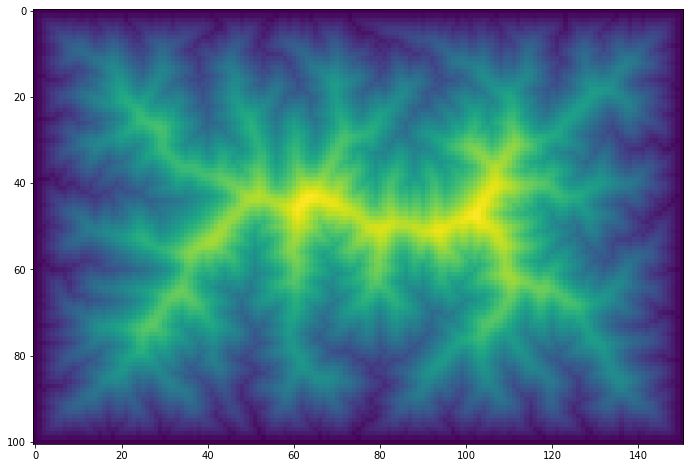

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(out_elevation_ref);

We now use the Neighborhood Algorithm to try to recover the input parameters

In [4]:
import neighborhood as nbr

For this we define an objective function that will be minimized by the NA. We simply take the L2-norm of the difference between two landscapes

In [5]:
def obj(xx):
    out_elevation_ref = np.load('elevation.npy')
    return np.linalg.norm(out_elevation_ref - run_fastscape(xx[0],xx[1],xx[2]))/out_elevation_ref.size

We perform the inversion with 10 iterations, each made of 10 samples with a resampling of 5 (see NA theory for further details)

Searcher(iteration=1, samples=10, best=7.536652e-01)
Searcher(iteration=2, samples=20, best=4.633418e-01)
Searcher(iteration=3, samples=30, best=3.706799e-01)
Searcher(iteration=4, samples=40, best=3.706799e-01)
Searcher(iteration=5, samples=50, best=3.706799e-01)
Searcher(iteration=6, samples=60, best=3.706799e-01)
Searcher(iteration=7, samples=70, best=3.706799e-01)
Searcher(iteration=8, samples=80, best=3.266050e-01)
Searcher(iteration=9, samples=90, best=3.208154e-01)
Searcher(iteration=10, samples=100, best=3.208154e-01)


/opt/homebrew/Caskroom/miniforge/base/envs/fastscape_Grenoble_test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/fastscape_Grenoble_test/lib/python3.8/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/fastscape_Grenoble_test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterp

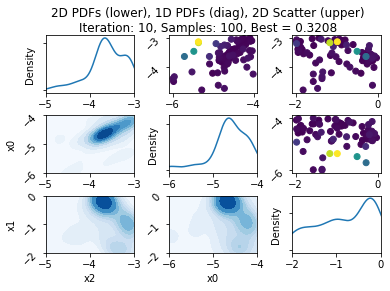

In [6]:
num_dim = 3
srch = nbr.Searcher(
    objective=obj,
    limits=[(-6,-4),(-2,0),(-5,-3)],
    num_samp=10,
    num_resamp=5,
    maximize=False,
    verbose=True
    )
srch.update(10)
srch.plot()